<a href="https://colab.research.google.com/github/craigybaeb/msc-car-gan/blob/main/DCGAN_Improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN to generate car images

**Author:** Craig Pirie
**Date created:** 2021/07/01<br>
**Last modified:** 2021/01/01<br>
**Description:** A DCGAN trained on Stanford Car images, based on the Keras demo implementation.

## Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
import tarfile
import glob
from PIL import Image
import cv2 as cv

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Prepare Stanford Car Dataset

We'll use car images from the Stanford dataset, resized to 64x64.

In [ ]:
os.makedirs("cars_gan")
os.makedirs("cars")
os.makedirs("augmented")

url = "http://ai.stanford.edu/~jkrause/car196/car_ims.tgz"
output = "cars_gan/data.tgz"
gdown.download(url, output, quiet=False)

tar = tarfile.open(output, "r:gz")
tar.extractall("/content/cars/")
tar.close()

## Augment the dataset
Increase the size of the dataset by rotating, skewing, zooming and flipping each image. End size should equal around the size of the CelebA dataset used in the Keras Demo.

In [ ]:
#instantiate the ImageDataGenerator class
datagen = ImageDataGenerator(
        rotation_range=40,
        height_shift_range=0.2,
        width_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
#loop over the data in batches and this automatically saves the images
i = 0
for batch in datagen.flow_from_directory('/content/cars', batch_size=12,target_size=(64,64),
                          save_to_dir='/content/augmented', save_format='jpg'):
    i += 1
    if i % 1000 == 0:
     print(str(i))

    if i == 16185:
      print("Finished augmentation.")
      break

Create a dataset from our folder, and rescale the images to the [0-1] range:

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "/content/augmented/", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 194187 files belonging to 1 classes.


Let's display a sample image:

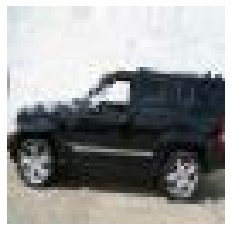

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

## Override `train_step`

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## Create a callback that periodically saves generated images

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/drive/My Drive/Masters/DCGAN_OUTPUT/generated_img_%03d_%d.png" % (epoch, i))

## Train the end-to-end model

## Default

In [ ]:
epochs = 20  #Ideally, this should be at least 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

### Learning Rate

In [ ]:
epochs = 20  #Ideally, this should be at least 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

### Dropout

In [ ]:
epochs = 20  #Ideally, this should be at least 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

## Alpha

In [ ]:
epochs = 20  #Ideally, this should be at least 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

# Evaluate FID Score

In [ ]:
from IPython.display import Image, display
!pip install pytorch-fid

In [ ]:
#Default
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/DCGAN_LAST'

tcmalloc: large alloc 3181559808 bytes == 0x5637a902e000 @  0x7f199fc621e7 0x7f199d6a246e 0x7f199d6f2c7b 0x7f199d6f335f 0x7f199d795103 0x563734971010 0x563734970da0 0x5637349e52f9 0x5637349dfc35 0x56373497273a 0x5637349e0b0e 0x5637349dfc35 0x56373497273a 0x5637349e0b0e 0x5637349e0235 0x56373497273a 0x5637349e0b0e 0x56373497265a 0x5637349e0b0e 0x56373497265a 0x5637349e4f40 0x5637349dfc35 0x5637349df933 0x5637349ddda0 0x563734970ea9 0x563734970da0 0x5637349e4bb3 0x5637349dfc35 0x56373497273a 0x5637349e0b0e 0x5637349dfc35
  0% 0/3884 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 3884/3884 [07:45<00:00,  8.35it/s]
tcm

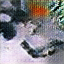

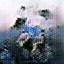

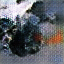

In [ ]:
display(Image('/content/drive/My Drive/Masters/DCGAN_LAST/Copy of generated_img_019_0.png'))
display(Image('/content/drive/My Drive/Masters/DCGAN_LAST/Copy of generated_img_019_1.png'))
display(Image('/content/drive/My Drive/Masters/DCGAN_LAST/Copy of generated_img_019_2.png'))

In [ ]:
#Learning Rate
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/DCGAN_LAST_LR'

tcmalloc: large alloc 3181559808 bytes == 0x555b68796000 @  0x7f8f90b261e7 0x7f8f8e56646e 0x7f8f8e5b6c7b 0x7f8f8e5b735f 0x7f8f8e659103 0x555af48e0010 0x555af48dfda0 0x555af49542f9 0x555af494ec35 0x555af48e173a 0x555af494fb0e 0x555af494ec35 0x555af48e173a 0x555af494fb0e 0x555af494f235 0x555af48e173a 0x555af494fb0e 0x555af48e165a 0x555af494fb0e 0x555af48e165a 0x555af4953f40 0x555af494ec35 0x555af494e933 0x555af494cda0 0x555af48dfea9 0x555af48dfda0 0x555af4953bb3 0x555af494ec35 0x555af48e173a 0x555af494fb0e 0x555af494ec35
  0% 0/3884 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 3884/3884 [07:45<00:00,  8.35it/s]
tcm

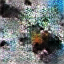

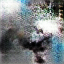

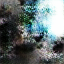

In [ ]:
display(Image('/content/drive/My Drive/Masters/DCGAN_LAST_LR/Copy of generated_img_019_0.png'))
display(Image('/content/drive/My Drive/Masters/DCGAN_LAST_LR/Copy of generated_img_019_1.png'))
display(Image('/content/drive/My Drive/Masters/DCGAN_LAST_LR/Copy of generated_img_019_2.png'))

In [ ]:
#Alpha
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/DCGAN_LAST_ALPHA'

tcmalloc: large alloc 3181559808 bytes == 0x562a1128e000 @  0x7f5a07bd51e7 0x7f5a0561546e 0x7f5a05665c7b 0x7f5a0566635f 0x7f5a05708103 0x56299d3d3010 0x56299d3d2da0 0x56299d4472f9 0x56299d441c35 0x56299d3d473a 0x56299d442b0e 0x56299d441c35 0x56299d3d473a 0x56299d442b0e 0x56299d442235 0x56299d3d473a 0x56299d442b0e 0x56299d3d465a 0x56299d442b0e 0x56299d3d465a 0x56299d446f40 0x56299d441c35 0x56299d441933 0x56299d43fda0 0x56299d3d2ea9 0x56299d3d2da0 0x56299d446bb3 0x56299d441c35 0x56299d3d473a 0x56299d442b0e 0x56299d441c35
  0% 0/3884 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 3884/3884 [07:44<00:00,  8.35it/s]
tcm

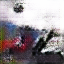

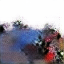

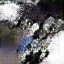

In [ ]:
display(Image('/content/drive/My Drive/Masters/DCGAN_LAST_ALPHA/Copy of generated_img_019_0.png'))
display(Image('/content/drive/My Drive/Masters/DCGAN_LAST_ALPHA/Copy of generated_img_019_1.png'))
display(Image('/content/drive/My Drive/Masters/DCGAN_LAST_ALPHA/Copy of generated_img_019_2.png'))

In [ ]:
#Dropout
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/DCGAN_LAST_DROPOUT'

tcmalloc: large alloc 3181559808 bytes == 0x5581047fa000 @  0x7fc7174511e7 0x7fc714e9146e 0x7fc714ee1c7b 0x7fc714ee235f 0x7fc714f84103 0x558090027010 0x558090026da0 0x55809009b2f9 0x558090095c35 0x55809002873a 0x558090096b0e 0x558090095c35 0x55809002873a 0x558090096b0e 0x558090096235 0x55809002873a 0x558090096b0e 0x55809002865a 0x558090096b0e 0x55809002865a 0x55809009af40 0x558090095c35 0x558090095933 0x558090093da0 0x558090026ea9 0x558090026da0 0x55809009abb3 0x558090095c35 0x55809002873a 0x558090096b0e 0x558090095c35
  0% 0/3884 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 3884/3884 [07:45<00:00,  8.35it/s]
tcm

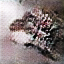

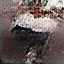

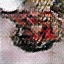

In [ ]:
display(Image('/content/drive/My Drive/Masters/DCGAN_LAST_DROPOUT/Copy of generated_img_019_0.png'))
display(Image('/content/drive/My Drive/Masters/DCGAN_LAST_DROPOUT/Copy of generated_img_019_1.png'))
display(Image('/content/drive/My Drive/Masters/DCGAN_LAST_DROPOUT/Copy of generated_img_019_2.png'))

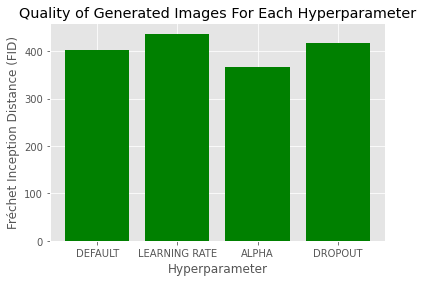

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['DEFAULT','LEARNING RATE','ALPHA','DROPOUT']
FID = [401.32222777301956, 436.6300097024655, 367.43088979717294, 417.8329016499472]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, FID, color='green')
plt.xlabel("Hyperparameter")
plt.ylabel("Fréchet Inception Distance (FID)")
plt.title("Quality of Generated Images For Each Hyperparameter")

plt.xticks(x_pos, x)

plt.show()